In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import imageio
import glob

In [2]:
data = open("results.p", "rb+")

In [3]:
unpickler = pickle.Unpickler(data)

In [4]:
training = unpickler.load()

In [5]:
data.close()

In [10]:
len(training)

10000

In [6]:
training[53]

[0.8790324058621061, -0.6127543650875391, 0, 0]

In [6]:
training_images = []
for image_path in sorted(glob.glob("/home/houcem/Documents/Data/rgb/*.png")):
    image = imageio.imread(image_path) 
    training_images.append(image)

In [8]:
len(training_images)

9999

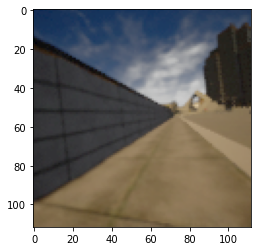

In [12]:
plt.imshow(training_images[9998])

In [7]:
training_images = np.asarray(training_images)

In [8]:
from tensorflow import keras

In [9]:
from keras.applications import ResNet50V2, MobileNetV2
from keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten, Concatenate, Reshape, BatchNormalization, Dropout
from keras.activations import relu, linear
from keras import Model

In [10]:
resnet = ResNet50V2(include_top=False, input_tensor=Input(shape=(112,112,3)), weights='imagenet')

In [11]:
resnet.trainable = False

In [22]:
mobilenet = MobileNetV2(include_top=False, input_tensor=Input(shape=(112,112,3)), weights='imagenet')

In [12]:
#Defining the motor input
y = Input(shape=(4,))


#Defining the ResNet Encoder input
image_input = Input(shape=(112,112,3,))
x = resnet(image_input)
x = Flatten()(x)

#Concatenating both vectors
concat = Concatenate()([x, y])

z = Dense(64, activation = 'relu')(concat)
z = Dense(128, activation = 'relu')(z)
z = Dense(512, activation = 'relu')(z)
z = Dense(784, activation= 'relu')(z)

encoder = Model(inputs= [y, image_input], outputs = z)

In [13]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
resnet50v2 (Model)              (None, 4, 4, 2048)   23564800    input_3[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 32768)        0           resnet50v2[1][0]                 
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
______________________________________________________________________________________________

In [14]:
input_decoder = Input(shape=(784,))

d = Reshape((28,28,1))(input_decoder)
d = Conv2DTranspose(128,(3, 3), strides=1, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(128,(3, 3), strides=1, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(128,(3, 3), strides=1, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(128,(3, 3), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(64,(3, 3), strides=1, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(64,(3, 3), strides=1, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(64,(3, 3), strides=1, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(32,(3, 3), activation='relu', padding='same')(d)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d)

Decoder = Model(inputs = input_decoder, outputs = decoded)

In [15]:
Decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 128)       1475

In [16]:
img_input = Input(shape=(112, 112, 3,))
motor_input = Input(shape=(4,))
Encoded = encoder([motor_input,img_input])
Decoded = Decoder(Encoded)

autoencoder = Model(inputs = [motor_input,img_input], outputs = Decoded)

# Preprocessing Data and Splitting the x and y

In [20]:
img_training_x=np.asarray(training_images[0:len(training) -3])
motor_training=np.asarray(training[0:len(training) -1])
img_training_y=np.asarray(training_images[1:len(training) -2])

In [18]:
autoencoder.compile(loss = 'mse', optimizer='adam')

In [19]:
autoencoder.fit(x=[motor_training,img_training_x], y=img_training_y, batch_size=4,epochs=20)

Epoch 1/20
2500/2500 [==============================] - 82s 33ms/step - loss: 9830.1191
Epoch 2/20
2500/2500 [==============================] - 82s 33ms/step - loss: 9829.8779
Epoch 3/20
2500/2500 [==============================] - 82s 33ms/step - loss: 9829.8760
Epoch 4/20
2500/2500 [==============================] - 81s 33ms/step - loss: 9829.87990s - loss: 9829.70
Epoch 5/20
2500/2500 [==============================] - 82s 33ms/step - loss: 9829.8789
Epoch 6/20
2500/2500 [==============================] - 81s 33ms/step - loss: 9829.8672
Epoch 7/20
2500/2500 [==============================] - 82s 33ms/step - loss: 9829.87790s - loss: 9830.
Epoch 8/20
2500/2500 [==============================] - 81s 33ms/step - loss: 9829.8760
Epoch 9/20
2500/2500 [==============================] - 81s 32ms/step - loss: 9829.8936
Epoch 10/20
2500/2500 [==============================] - 81s 32ms/step - loss: 9829.8926
Epoch 11/20
2500/2500 [==============================] - 81s 32ms/step - loss: 9829.8